In [1]:
import numpy as np
import scipy
from harris import *
import cv2
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import random
import numpy.linalg as LA
import skimage.transform
from skimage.transform import *

In [2]:
import matplotlib.pyplot as plt

In [3]:
### Constants

## This one must be odd
neighborhood_size = 51
top_match_count = 1000

In [4]:
left = np.array(Image.open("left.jpg").convert("L"))
right = np.array(Image.open("right.jpg").convert("L"))



'\nright_kp, right_des = cv2.xfeatures2d.SIFT_create().detectAndCompute(right, None)\nright_with_keypoints = cv2.drawKeypoints(right, right_kp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)\nplt.imshow(right_with_keypoints)\n'

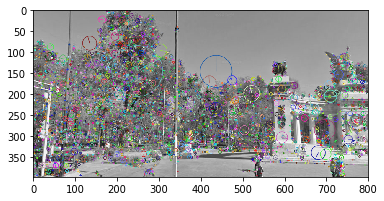

In [5]:
"""
leftharrisim = compute_harris_response(left)
left_points = get_harris_points(leftharrisim)
rightharrisim = compute_harris_response(right)
right_points = get_harris_points(rightharrisim)
"""
using_sift = True

left_kp, left_des = cv2.xfeatures2d.SIFT_create().detectAndCompute(left, None)
left_img = cv2.imread('left.jpg')
left_img = cv2.drawKeypoints(left, left_kp, left_img, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(left_img)

"""
right_kp, right_des = cv2.xfeatures2d.SIFT_create().detectAndCompute(right, None)
right_with_keypoints = cv2.drawKeypoints(right, right_kp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(right_with_keypoints)
"""



In [6]:
def extract_neighborhood(im, points, size=neighborhood_size, sift=using_sift, descriptors=None):
    if sift:
        return descriptors
    points = points.astype(np.int32)
    im = np.pad(im, int(size / 2), mode='wrap')
    flattened_neighborhoods = []
    for i in range(len(points)):
        x, y = np.array(points[i])
        neighborhood = im[x:x+size,y:y+size]
        
        flattened_neighborhoods.append(neighborhood.flatten())
    
    output = np.array(flattened_neighborhoods)
    return output
    

In [7]:
def normalize(X):
    output = (X - np.expand_dims(X.mean(1), 1)) / np.expand_dims(X.std(1), 1)
    return output

In [8]:
def compute_distances(left_neighborhoods, right_neighborhoods):
    return scipy.spatial.distance.cdist(normalize(left_neighborhoods), normalize(right_neighborhoods), 'sqeuclidean')
    

In [9]:
def get_matches(image1, image2, count=top_match_count):
    
    left_kp, left_des = cv2.xfeatures2d.SIFT_create().detectAndCompute(left, None)
    right_kp, right_des = cv2.xfeatures2d.SIFT_create().detectAndCompute(right, None)
    left_kp = np.flip(np.array([left_kp[i].pt for i in range(len(left_kp))]), axis=1)
    right_kp = np.flip(np.array([right_kp[i].pt for i in range(len(right_kp))]), axis=1)
    """
    leftharrisim = compute_harris_response(image1)
    left_kp = np.array(get_harris_points(leftharrisim))
    rightharrisim = compute_harris_response(image2)
    right_kp = np.array(get_harris_points(rightharrisim))
    """
    ### feature distances
    first_neighborhoods = extract_neighborhood(image1, left_kp, descriptors=left_des)
    second_neighborhoods = extract_neighborhood(image2, right_kp, descriptors=right_des)
    
    distances = compute_distances(first_neighborhoods, second_neighborhoods)
    
    
    ### neighborhood distances
    first_neighborhoods = extract_neighborhood(image1, left_kp, sift=False)
    second_neighborhoods = extract_neighborhood(image2, right_kp, sift=False)
    neighborhood_distances = compute_distances(first_neighborhoods, second_neighborhoods)
    
    ### Tricky attempt to factor in neighborhood similarity and sift feature similarity
    distances = distances * neighborhood_distances
    
    
    idx = np.argpartition(distances.ravel(), count)
    matches = tuple(np.array(np.unravel_index(idx, distances.shape))[:, range(min(count, 0), max(count, 0))])
    
    
    
    match_locations = np.array([left_kp[matches[0]], right_kp[matches[1]]])
    
    return match_locations
    

In [10]:
"""
    x: (N, 2)
    x_prime: (N, 2)
"""
def compute_A(x, x_prime):
    (N, _) = x.shape
    local_x = np.concatenate([x, np.ones((N,1))], axis=1)
    local_x_prime = np.concatenate([x_prime, np.ones((N,1))], axis=1)
    
    A = np.zeros((2*N, 9))
    
    A[::2,3:6] = local_x
    A[1::2,0:3] = local_x
    A[::2,6:9] = -local_x_prime[:,[1]] * local_x
    A[1::2,6:9] = -local_x_prime[:,[0]] * local_x
    
    return A
    
    

In [11]:
def homography_fit(x, x_prime):
    A = compute_A(x, x_prime)
    #ATA = np.matmul(A.T, A)
    U, s, V = LA.svd(A)
    solution = V[-1]
    return A, solution

In [12]:
def compute_loss(x, x_prime, solution):
    (N, _) = x.shape
    local_x = np.concatenate([x, np.ones((N,1))], axis=1)
    local_x_prime = np.concatenate([x_prime, np.ones((N,1))], axis=1)
    local_solution = solution.reshape((3,3))
    
    Hx = np.matmul(local_solution, local_x.T)
    Hx /= Hx[[2]]
    Hx = Hx[:2]
    loss = np.sqrt( np.sum( (Hx - local_x_prime.T[:2]) ** 2, axis=0 ) )
    
    return loss

In [13]:
def find_inliers(x, x_prime, solution, threshold=7.0):
    
    loss = compute_loss(x, x_prime, solution)
    #print("local_x: ", local_x, "local_x_prime: ", local_x_prime, "Hx: ", Hx)
    inlier = (loss < threshold)
    
    inlier_points = np.array([x[inlier], x_prime[inlier]])
    return inlier_points
    

In [14]:
def RANSAC_homography_estimation(image1, image2, first_loc, second_loc):
    
    (_, N, _) = match_locations.shape
    inlier_threshold = 10
    
    ## Stores inliers, is only added to over time
    
    samp = random.sample(list(range(N)), 4)
    inliers = np.array([first_loc[samp], second_loc[samp]])
    solution = None
    num_iters = 1000
    
    best_solution = None
    best_inliers = None
    best_num_matches = 0
    
    for i in range(num_iters):
        #print("Iteration: %d. Num inliers: %d" % (i, inliers.shape[1]))
        _, solution = homography_fit(inliers[0], inliers[1])
        new_first, new_second = new_inliers = find_inliers(first_loc, second_loc, solution)
        if (inliers.shape[1] < inlier_threshold):
            inliers = np.concatenate([inliers, new_inliers], axis=1)
        
        if (new_inliers.shape[1] > best_num_matches):
            best_num_matches = new_inliers.shape[1]
            best_solution = solution
            best_inliers = inliers
        
        else:
            inliers = new_inliers
            
            if (i != num_iters-1):
                samp = random.sample(range(N), 4)
                samp = np.array([first_loc[samp], second_loc[samp]])
                inliers = np.concatenate([inliers, samp], axis=1)
            
        if (inliers.shape[1] < inlier_threshold):
            samp = random.sample(range(N), 4)
            inliers = np.array([first_loc[samp], second_loc[samp]])
            
        
            
    return best_solution, best_inliers
    
        

In [15]:
left_loc, right_loc = match_locations = get_matches(left, right)

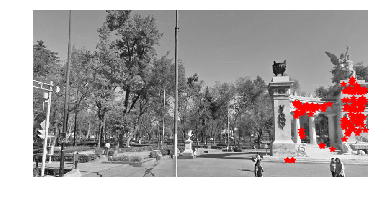

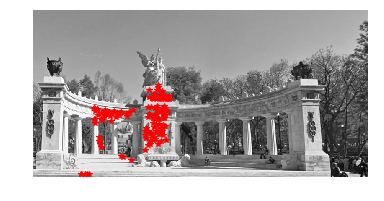

There are 153 inliers. The residual loss of the transformation is 1.830950.


In [16]:
solution, inliers = RANSAC_homography_estimation(left, right, left_loc, right_loc)
plot_harris_points(left, inliers[0])
plot_harris_points(right, inliers[1])

residual = compute_loss(inliers[0], inliers[1], solution)

print("There are %d inliers. The residual loss of the transformation is %f." % (inliers.shape[1], np.mean(residual)))

In [17]:

def warp_images(image0, image1, transform):
    r, c = image1.shape[:2]
    # Note that transformations take coordinates in (x, y) format,
    # not (row, column), in order to be consistent with most literature
    corners = np.array([[0, 0],
                        [0, r],
                        [c, 0],
                        [c, r]])

    # Warp the image corners to their new positions
    warped_corners = transform(corners)

    # Find the extents of both the reference image and the warped
    # target image
    all_corners = np.vstack((warped_corners, corners))

    corner_min = np.min(all_corners, axis=0)
    corner_max = np.max(all_corners, axis=0)

    output_shape = (corner_max - corner_min)
    output_shape = np.ceil(output_shape[::-1])

    offset = SimilarityTransform(translation=-corner_min)

    image0_ = warp(image0, offset.inverse, output_shape=output_shape, cval=-1)

    image1_ = warp(image1, (transform + offset).inverse, output_shape=output_shape, cval=-1)

    image0_zeros = warp(image0, offset.inverse, output_shape=output_shape, cval=0)

    image1_zeros = warp(image1, (transform + offset).inverse, output_shape=output_shape, cval=0)

    overlap = (image0_ != -1.0 ).astype(int) + (image1_ != -1.0).astype(int)
    overlap += (overlap < 1).astype(int)
    print(overlap, np.max(overlap), np.min(overlap))
    merged = (image0_zeros+image1_zeros)/overlap
    
    ### Added by me
    merged[overlap == 2] = image1_zeros[overlap == 2]
    print(merged.shape)
    merged = np.flip(merged, axis=2)

    im = Image.fromarray((255*merged).astype('uint8'), mode='RGB')
    im.save('stitched_images.jpg')
    im.show()

[[[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 ...

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [1 1 1]
  [1 1 1]
  [1 1 1]]] 2 1
(1673, 3723, 3)


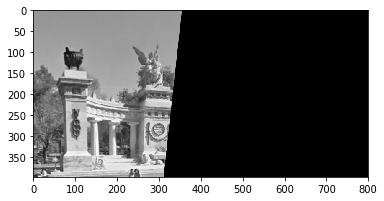

In [18]:
solution = solution.reshape((3,3))
solution = solution[[1,0,2]]
solution = solution[:,[1, 0, 2]]
#solution = np.eye(3)
#solution[0,2] -= 200
#solution[0,2] += 800
transform = skimage.transform.ProjectiveTransform(solution)
left_trans = skimage.transform.warp(left, transform.inverse)
plt.imshow(left_trans)

left_img = cv2.imread('left.jpg')
right_img = cv2.imread('right.jpg')

warp_images(right_img, left_img, transform)


In [19]:
warp_images(right_img, left_img, transform)

[[[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 ...

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [1 1 1]
  [1 1 1]
  [1 1 1]]] 2 1
(1673, 3723, 3)
